<a href="https://colab.research.google.com/github/Iliasecc/Projets_Finance/blob/main/Projet_SgATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

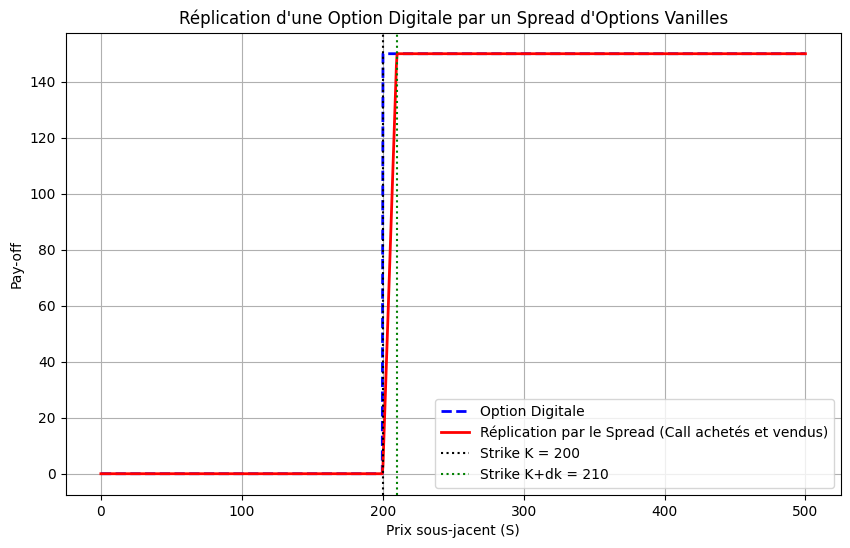

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du modèle
K =  200     # Strike de l'option digitale
dk = 10      # Différence entre les strikes des options vanilles
S = np.linspace(0, 500, 1000)  # Gamme de prix sous-jacents de 0 à 600

# Option digitale : pay-off 1 si S > K, sinon 0
payoff_digitale = np.where(S > K, 1, 0)
payoff_digitale=[0 if x<K else 150 for x in S]
# Option vanilla call achetée avec strike K
payoff_call_achete = np.maximum(S - K, 0)

# Option vanilla call vendue avec strike K + dk
payoff_call_vendu = np.maximum(S - (K + dk), 0)

# Replication de l'option digitale par un spread d'options vanilles
payoff_replique =150/10*( payoff_call_achete - payoff_call_vendu)

# Tracer les pay-offs
plt.figure(figsize=(10, 6))
plt.plot(S, payoff_digitale, label='Option Digitale', color='blue', linestyle='--', linewidth=2)
plt.plot(S, payoff_replique, label='Réplication par le Spread (Call achetés et vendus)', color='red', linewidth=2)
plt.axvline(K, color='black', linestyle=':', label=f'Strike K = {K}')
plt.axvline(K + dk, color='green', linestyle=':', label=f'Strike K+dk = {K + dk}')
plt.title("Réplication d'une Option Digitale par un Spread d'Options Vanilles")
plt.xlabel("Prix sous-jacent (S)")
plt.ylabel("Pay-off")
plt.legend()
plt.grid(True)
plt.show()


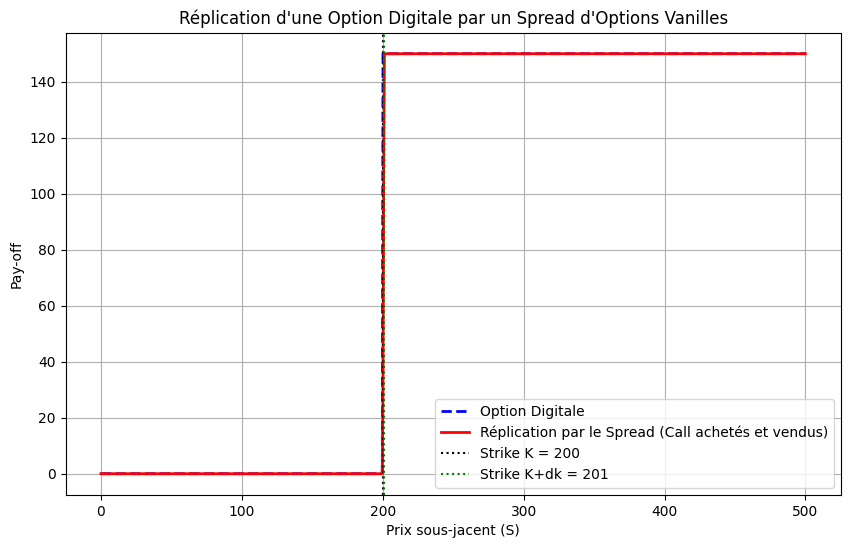

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du modèle
K =  200     # Strike de l'option digitale
dk = 1      # Différence entre les strikes des options vanilles
S = np.linspace(0, 500, 1000)  # Gamme de prix sous-jacents de 0 à 600

# Option digitale : pay-off 1 si S > K, sinon 0

payoff_digitale=[0 if x<K else 150 for x in S]
# Option vanilla call achetée avec strike K
payoff_call_achete = np.maximum(S - K, 0)

# Option vanilla call vendue avec strike K + dk
payoff_call_vendu = np.maximum(S - (K + dk), 0)

# Replication de l'option digitale par un spread d'options vanilles
payoff_replique =150/1*( payoff_call_achete - payoff_call_vendu)

# Tracer les pay-offs
plt.figure(figsize=(10, 6))
plt.plot(S, payoff_digitale, label='Option Digitale', color='blue', linestyle='--', linewidth=2)
plt.plot(S, payoff_replique, label='Réplication par le Spread (Call achetés et vendus)', color='red', linewidth=2)
plt.axvline(K, color='black', linestyle=':', label=f'Strike K = {K}')
plt.axvline(K + dk, color='green', linestyle=':', label=f'Strike K+dk = {K + dk}')
plt.title("Réplication d'une Option Digitale par un Spread d'Options Vanilles")
plt.xlabel("Prix sous-jacent (S)")
plt.ylabel("Pay-off")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def black_scholes_delta_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1


In [3]:
# Fonction de coût pour évaluer la performance du portefeuille avec calls et puts
def cost_function(n_calls, n_puts, S0, strikes, T, r, sigma, target_payoff, n_steps):
    dt = T / n_steps
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    calls_weights = np.zeros((n_steps + 1, n_calls))
    puts_weights = np.zeros((n_steps + 1, n_puts))
    portfolio_value = np.zeros(n_steps + 1)

    for t in range(n_steps):
        T_remaining = T - (t * dt)
        call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        put_prices = [black_scholes_put(S_path[t], K, T_remaining, r, sigma) for K in strikes[n_calls:n_calls + n_puts]]

        deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in strikes[:n_calls]]
        deltas_puts = [black_scholes_delta_put(S_path[t], K, T_remaining, r, sigma) for K in strikes[n_calls:n_calls + n_puts]]

        current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(n_calls)) + \
                                  sum(puts_weights[t, j] * put_prices[j] for j in range(n_puts))

        needed_adjustment = target_payoff - current_portfolio_value

        # Ajuster les poids des calls
        for i in range(n_calls):
            calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

        # Ajuster les poids des puts
        for j in range(n_puts):
            puts_weights[t + 1, j] = puts_weights[t, j] + (needed_adjustment * dt) * deltas_puts[j]

        portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(n_calls)) + \
                                  sum(puts_weights[t + 1, j] * put_prices[j] for j in range(n_puts))

    return abs(portfolio_value[-1] - target_payoff), strikes  # Retourner l'écart absolu et les strikes

In [42]:
# Paramètres du modèle
S0 = 100  # Prix initial de l'actif sous-jacent
T = 1/6  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

Nombre optimal d'options d'achat : 1
Nombre optimal d'options de vente : 3
Strikes des options optimales : [ 72.02309276 103.78617916  82.26029454 110.56731966  75.67514044
 124.21025548  98.24234082  91.60777672 108.82773338  76.82415287]
Informations sur les options sélectionnées :
Type: call, Strike: 72.02309276065253, Échéance: 0.25 ans
Type: put, Strike: 103.78617916256738, Échéance: 0.25 ans
Type: put, Strike: 82.2602945353762, Échéance: 0.25 ans
Type: put, Strike: 110.56731965983778, Échéance: 0.25 ans
Pas de temps 0: Valeur du portefeuille = 0.41
Pas de temps 1: Valeur du portefeuille = 0.88
Pas de temps 2: Valeur du portefeuille = 1.36
Pas de temps 3: Valeur du portefeuille = 1.95
Pas de temps 4: Valeur du portefeuille = 2.86
Pas de temps 5: Valeur du portefeuille = 2.95
Pas de temps 6: Valeur du portefeuille = 3.63
Pas de temps 7: Valeur du portefeuille = 3.56
Pas de temps 8: Valeur du portefeuille = 3.57
Pas de temps 9: Valeur du portefeuille = 4.36
Pas de temps 10: Valeur d

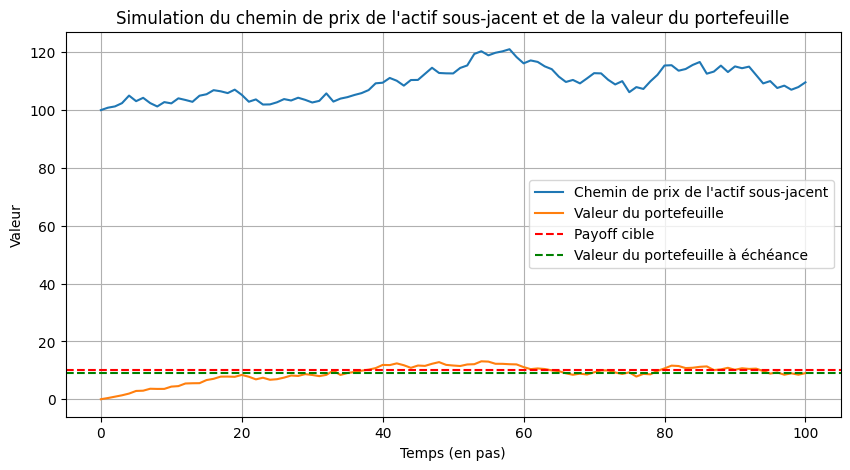

Valeur cible du payoff de l'option digitale : 10
Valeur finale du portefeuille à l'échéance : 9.027711688940494
Erreur : -0.972288311059506
Payoff final du portefeuille de réplication : 38.54422689918525


In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du modèle
S0 = 100  # Prix initial de l'actif sous-jacent
T = 1/4  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Définir le marché des options
strikes = np.random.uniform(70, 130, 10)
options_market = {
    'calls': {K: black_scholes_call(S0, K, T, r, sigma) for K in strikes},
    'puts': {K: black_scholes_put(S0, K, T, r, sigma) for K in strikes}
}

# Valeur fixe de payoff de l'option digitale
target_payoff = 10  # Valeur connue pour le payoff de l'option digitale

# Tester différentes combinaisons d'options vanilles
optimal_n_calls = None
optimal_n_puts = None
min_cost = float('inf')
optimal_strikes = None  # Pour stocker les strikes optimaux
selected_options_info = []  # Pour stocker les informations des options sélectionnées

# Tester toutes les combinaisons possibles de calls et puts
for n_calls in range(1, len(strikes) // 2 + 1):
    for n_puts in range(1, len(strikes) // 2 + 1):
        cost, strikes = cost_function(n_calls, n_puts, S0, strikes, T, r, sigma, target_payoff, n_steps)
        if cost < min_cost:
            min_cost = cost
            optimal_n_calls = n_calls
            optimal_n_puts = n_puts
            optimal_strikes = strikes  # Store the optimal strikes

# Collecter les informations des options optimales
for K in optimal_strikes[:optimal_n_calls]:
    selected_options_info.append({
        'type': 'call',
        'strike': K,
        'expiration': T
    })

for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]:
    selected_options_info.append({
        'type': 'put',
        'strike': K,
        'expiration': T
    })

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Nombre optimal d'options de vente : {optimal_n_puts}")
print(f"Strikes des options optimales : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")

# Simulation du chemin de prix de l'actif sous-jacent
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

# Simuler le chemin de prix de l'actif sous-jacent pour le nombre optimal d'options
for t in range(1, n_steps + 1):
    Z = np.random.normal()
    S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

calls_weights = np.zeros((n_steps + 1, optimal_n_calls))
puts_weights = np.zeros((n_steps + 1, optimal_n_puts))
portfolio_value = np.zeros(n_steps + 1)

# Calcul de la valeur du portefeuille au fil du temps
for t in range(n_steps):
    T_remaining = T - (t * dt)
    call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    put_prices = [black_scholes_put(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]]

    deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    deltas_puts = [black_scholes_delta_put(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]]

    current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(optimal_n_calls)) + \
                              sum(puts_weights[t, j] * put_prices[j] for j in range(optimal_n_puts))

    needed_adjustment = target_payoff - current_portfolio_value

    # Ajuster les poids des calls
    for i in range(optimal_n_calls):
        calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

    # Ajuster les poids des puts
    for j in range(optimal_n_puts):
        puts_weights[t + 1, j] = puts_weights[t, j] + (needed_adjustment * dt) * deltas_puts[j]

    portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(optimal_n_calls)) + \
                              sum(puts_weights[t + 1, j] * put_prices[j] for j in range(optimal_n_puts))

    # Affichage de la valeur du portefeuille à chaque pas de temps
    print(f"Pas de temps {t}: Valeur du portefeuille = {portfolio_value[t + 1]:.2f}")

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.plot(portfolio_value, label='Valeur du portefeuille')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent et de la valeur du portefeuille')
plt.xlabel('Temps (en pas)')
plt.ylabel('Valeur')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.axhline(y=portfolio_value[-1], color='g', linestyle='--', label='Valeur du portefeuille à échéance')
plt.legend()
plt.grid()
plt.show()

# Affichage des résultats
final_price = S_path[-1]  # Prix de l'actif sous-jacent à la fin de la simulation

# Calculer le payoff des options d'achat et de vente
payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])
payoff_puts = sum(max(0, K - final_price) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts])

# Le payoff total du portefeuille de réplication
total_payoff = payoff_calls + payoff_puts

# Affichage des résultats finaux
print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
print(f"Valeur finale du portefeuille à l'échéance : {portfolio_value[-1]}")
print(f"Erreur : {portfolio_value[-1]-target_payoff}")
print(f"Payoff final du portefeuille de réplication : {total_payoff}")


Nombre optimal d'options d'achat : 15
Nombre optimal d'options de vente : 13
Strikes des options optimales : [103.71995726 121.08070932  88.86602689 115.0547943  115.73980974
 125.28124159 124.46687566  87.25626089  90.09404066  93.5598866
  71.92170558  89.88885932  96.26651381  87.50163937 117.98368788
  86.75411864  87.45712407 111.53003103  84.78193759 111.96239386
 109.14699803 102.42655151  85.52977399 120.22720886  70.72872922
 128.24368697  90.81546487 109.22059746  89.86878499  95.55009176]
Informations sur les options sélectionnées :
Type: call, Strike: 103.71995726258868, Échéance: 0.25 ans
Type: call, Strike: 121.08070932362645, Échéance: 0.25 ans
Type: call, Strike: 88.86602688970918, Échéance: 0.25 ans
Type: call, Strike: 115.05479429620911, Échéance: 0.25 ans
Type: call, Strike: 115.73980974117278, Échéance: 0.25 ans
Type: call, Strike: 125.28124159360605, Échéance: 0.25 ans
Type: call, Strike: 124.46687565731206, Échéance: 0.25 ans
Type: call, Strike: 87.25626088827036,

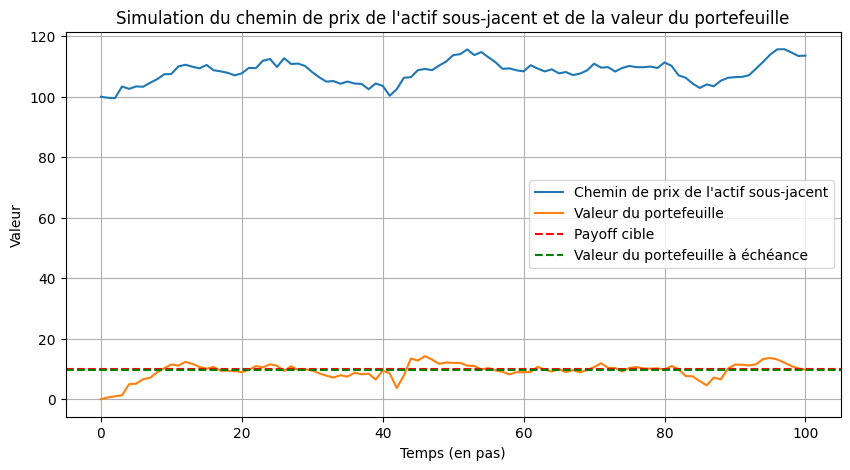

Valeur cible du payoff de l'option digitale : 10
Valeur finale du portefeuille à l'échéance : 9.757349973176712
Erreur : -0.24265002682328785
Payoff final du portefeuille de réplication : 234.6550470589427


In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du modèle
S0 = 100  # Prix initial de l'actif sous-jacent
T = 1/4  # Temps à maturité
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
n_steps = 100  # Nombre de pas de temps

# Définir le marché des options
strikes = np.random.uniform(70, 130, 30)
options_market = {
    'calls': {K: black_scholes_call(S0, K, T, r, sigma) for K in strikes},
    'puts': {K: black_scholes_put(S0, K, T, r, sigma) for K in strikes}
}

# Valeur fixe de payoff de l'option digitale
target_payoff = 10  # Valeur connue pour le payoff de l'option digitale

# Tester différentes combinaisons d'options vanilles
optimal_n_calls = None
optimal_n_puts = None
min_cost = float('inf')
optimal_strikes = None  # Pour stocker les strikes optimaux
selected_options_info = []  # Pour stocker les informations des options sélectionnées

# Tester toutes les combinaisons possibles de calls et puts
for n_calls in range(1, len(strikes) // 2 + 1):
    for n_puts in range(1, len(strikes) // 2 + 1):
        cost, strikes = cost_function(n_calls, n_puts, S0, strikes, T, r, sigma, target_payoff, n_steps)
        if cost < min_cost:
            min_cost = cost
            optimal_n_calls = n_calls
            optimal_n_puts = n_puts
            optimal_strikes = strikes  # Store the optimal strikes

# Collecter les informations des options optimales
for K in optimal_strikes[:optimal_n_calls]:
    selected_options_info.append({
        'type': 'call',
        'strike': K,
        'expiration': T
    })

for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]:
    selected_options_info.append({
        'type': 'put',
        'strike': K,
        'expiration': T
    })

print(f"Nombre optimal d'options d'achat : {optimal_n_calls}")
print(f"Nombre optimal d'options de vente : {optimal_n_puts}")
print(f"Strikes des options optimales : {optimal_strikes}")
print("Informations sur les options sélectionnées :")
for option in selected_options_info:
    print(f"Type: {option['type']}, Strike: {option['strike']}, Échéance: {option['expiration']} ans")

# Simulation du chemin de prix de l'actif sous-jacent
dt = T / n_steps
S_path = np.zeros(n_steps + 1)
S_path[0] = S0

# Simuler le chemin de prix de l'actif sous-jacent pour le nombre optimal d'options
for t in range(1, n_steps + 1):
    Z = np.random.normal()
    S_path[t] = S_path[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

calls_weights = np.zeros((n_steps + 1, optimal_n_calls))
puts_weights = np.zeros((n_steps + 1, optimal_n_puts))
portfolio_value = np.zeros(n_steps + 1)

# Calcul de la valeur du portefeuille au fil du temps
for t in range(n_steps):
    T_remaining = T - (t * dt)
    call_prices = [black_scholes_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    put_prices = [black_scholes_put(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]]

    deltas_calls = [black_scholes_delta_call(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[:optimal_n_calls]]
    deltas_puts = [black_scholes_delta_put(S_path[t], K, T_remaining, r, sigma) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts]]

    current_portfolio_value = sum(calls_weights[t, i] * call_prices[i] for i in range(optimal_n_calls)) + \
                              sum(puts_weights[t, j] * put_prices[j] for j in range(optimal_n_puts))

    needed_adjustment = target_payoff - current_portfolio_value

    # Ajuster les poids des calls
    for i in range(optimal_n_calls):
        calls_weights[t + 1, i] = calls_weights[t, i] + (needed_adjustment * dt) * deltas_calls[i]

    # Ajuster les poids des puts
    for j in range(optimal_n_puts):
        puts_weights[t + 1, j] = puts_weights[t, j] + (needed_adjustment * dt) * deltas_puts[j]

    portfolio_value[t + 1] = sum(calls_weights[t + 1, i] * call_prices[i] for i in range(optimal_n_calls)) + \
                              sum(puts_weights[t + 1, j] * put_prices[j] for j in range(optimal_n_puts))

    # Affichage de la valeur du portefeuille à chaque pas de temps
    print(f"Pas de temps {t}: Valeur du portefeuille = {portfolio_value[t + 1]:.2f}")

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(S_path, label='Chemin de prix de l\'actif sous-jacent')
plt.plot(portfolio_value, label='Valeur du portefeuille')
plt.title('Simulation du chemin de prix de l\'actif sous-jacent et de la valeur du portefeuille')
plt.xlabel('Temps (en pas)')
plt.ylabel('Valeur')
plt.axhline(y=target_payoff, color='r', linestyle='--', label='Payoff cible')
plt.axhline(y=portfolio_value[-1], color='g', linestyle='--', label='Valeur du portefeuille à échéance')
plt.legend()
plt.grid()
plt.show()

# Affichage des résultats
final_price = S_path[-1]  # Prix de l'actif sous-jacent à la fin de la simulation

# Calculer le payoff des options d'achat et de vente
payoff_calls = sum(max(0, final_price - K) for K in optimal_strikes[:optimal_n_calls])
payoff_puts = sum(max(0, K - final_price) for K in optimal_strikes[optimal_n_calls:optimal_n_calls + optimal_n_puts])

# Le payoff total du portefeuille de réplication
total_payoff = payoff_calls + payoff_puts

# Affichage des résultats finaux
print(f"Valeur cible du payoff de l'option digitale : {target_payoff}")
print(f"Valeur finale du portefeuille à l'échéance : {portfolio_value[-1]}")
print(f"Erreur : {portfolio_value[-1]-target_payoff}")
print(f"Payoff final du portefeuille de réplication : {total_payoff}")
